# Bidisperse simulations

In this notebook we will show how to do simulations with different types of particles. The same principle should be applied for simulations with several types of traps.

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.insert(0, '../../')

import magcolloids as mgc

from IPython.display import HTML

idx = pd.IndexSlice

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
ureg = mgc.ureg

## Several types of particles:

A `particles` object creates one type of particles, with a fixed set of parameters. In the simulation, this particle is copied many times to the positions given by `positions`. 

To create a simulation with several types of particles, it is necessary to create different instances of `particles`. The `sim` and `world` objects accept an array of particles as arguments.

In [4]:
region = np.array([20,20,4.1])

In [5]:
particles = mgc.particles(
    np.array([[-5,0,0],[0,5,0],[5,0,0]])*ureg.um,
    radius = 2*ureg.um,
    susceptibility = 1,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

particles2 = mgc.particles(
    np.array([[-5,-3,0],[0,-3,0],[5,-3,0],[5,5,0]])*ureg.um,
    radius = 1*ureg.um,
    susceptibility = 1,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

In [6]:
field = mgc.field(magnitude = 3*ureg.mT, frequency = 100*ureg.Hz, angle = 90*ureg.degrees)

world = mgc.world([particles,particles2], temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 20*ureg.um)

sim = mgc.sim(dir_name = "bidisperse/", file_name = "test_particles",
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = 30*ureg.s,
       particles = [particles,particles2], world = world, field = field, 
       output = ["x","y","z","mux","muy","muz"])

In [7]:
sim.generate_scripts()
sim.run()
sim.load()

scanning file


  0%|          | 0/663802 [00:00<?, ?it/s]

In [8]:
trj = sim.lazy_read[:]

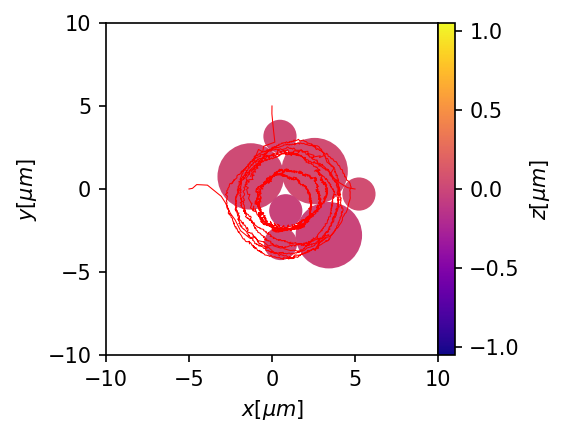

In [9]:
plt.figure(figsize=(3,3),dpi=150)
ax = mgc.draw_trj(trj,sim,cmap="plasma")
for i, trj_i in trj.groupby("id"):
    if all(trj_i.type==1):
        ax.plot(trj_i.x,trj_i.y, color="red",linewidth = 0.5)

## Bidisperse traps

Just as `particles` object, the `bistable_trap` object creates a type of trap. Here as well, we must create different types of traps to give them different parameters. 

However, we must also specify the particles that will be affected by each trap. This is done by the `particles` argument. If we want a specific `bistable_trap` object to act only on some of the copies of the object `particles`, we can give it a subset specification. The subset can be a slice, or an array of indices which points to the particle in position $i$ inside the `particles` object. 

In [10]:
region = np.array([20,20,4.1])

In [11]:
particles = mgc.particles(
    np.array([[-5,0,0],[0,5,0],[5,0,0]])*ureg.um,
    radius = 2*ureg.um,
    susceptibility = 1,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

traps = mgc.bistable_trap(
                np.array([[-5,0,0],[0,5,0]])*ureg.um,
                np.array([[1,0,0],[0,1,0]]),
                particles, subsets = slice(0,2),
                distance = 2*ureg.um,
                height = 0 * ureg.pN*ureg.nm,
                stiffness = 3e-4 * ureg.pN/ureg.nm)

traps2 = mgc.bistable_trap(
                np.array([[5,0,0]])*ureg.um,
                np.array([[1,0,0]]),
                particles, subsets = [2],
                distance = 0*ureg.um,
                height = 0 * ureg.pN*ureg.nm,
                stiffness = 3e-4 * ureg.pN/ureg.nm)

In [12]:
field = mgc.field(magnitude = 0*ureg.mT, frequency = 100*ureg.Hz, angle = 90*ureg.degrees)

world = mgc.world(particles, [traps,traps2], temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 20*ureg.um)

sim = mgc.sim(dir_name = "bidisperse/", file_name = "test_traps",
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = 60*ureg.s,
       particles = particles,traps = [traps,traps2], world = world, field = field, 
       output = ["x","y","z","mux","muy","muz"])

In [13]:
sim.generate_scripts()
sim.run()
sim.load()

trj = sim.lazy_read[:]

scanning file


  0%|          | 0/768584 [00:00<?, ?it/s]

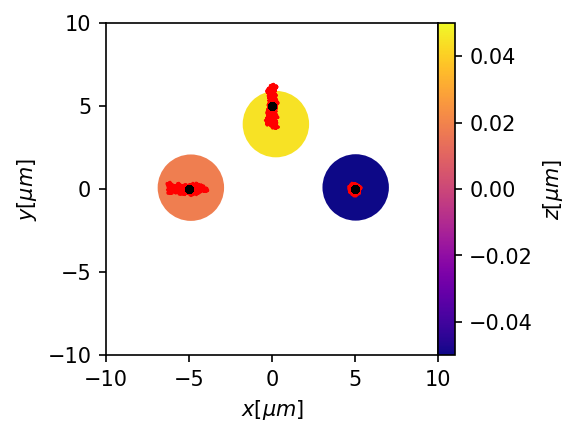

In [14]:
plt.figure(figsize=(3,3),dpi=150)
ax = mgc.draw_trj(trj[trj.type==1],sim,cmap="plasma")

for i, trj_i in trj.groupby("id"):
    if all(trj_i.type==1):
        ax.plot(trj_i.x,trj_i.y, color="red")
    else: 
        ax.plot(trj_i.x,trj_i.y,'.',color="k", linewidth = .5)

### What happens if some of the traps are pair traps?

Pair traps are not assigned a bond to a specific trap, but instead they act on whatever particles are inside their cutoff (pair traps *must* have a cutoff).

In [15]:
region = np.array([20,20,4.1])

In [16]:
particles = mgc.particles(
    np.array([[-5,0,0],[0,5,0],[5,0,0]])*ureg.um,
    radius = 2*ureg.um,
    susceptibility = 1,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

traps = mgc.bistable_trap(
                np.array([[-5,0,0],[0,5,0]])*ureg.um,
                np.array([[1,0,0],[0,1,0]]),
                particles, subsets = slice(0,2),
                distance = 2*ureg.um,
                height = 0 * ureg.pN*ureg.nm,
                stiffness = 3e-4 * ureg.pN/ureg.nm)

traps2 = mgc.bistable_trap(
                np.array([[5,0,0]])*ureg.um,
                np.array([[1,0,0]]),
                particles, subsets = [2],
                distance = 0*ureg.um,
                height = 0 * ureg.pN*ureg.nm,
                stiffness = 1e-4 * ureg.pN/ureg.nm,
                cutoff = 1*ureg.um)

In [17]:
field = mgc.field(magnitude = 0*ureg.mT, frequency = 100*ureg.Hz, angle = 90*ureg.degrees)

world = mgc.world(particles, [traps,traps2], temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 20*ureg.um)

In [18]:
sim = mgc.sim(dir_name = "bidisperse/", file_name = "test_traps_pair",
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = 60*ureg.s,
       particles = particles,traps = [traps,traps2], world = world, field = field, 
       output = ["x","y","z","mux","muy","muz"])

In [19]:
sim.generate_scripts()
sim.run()
sim.load()

trj = sim.lazy_read[:]

scanning file


  0%|          | 0/767832 [00:00<?, ?it/s]

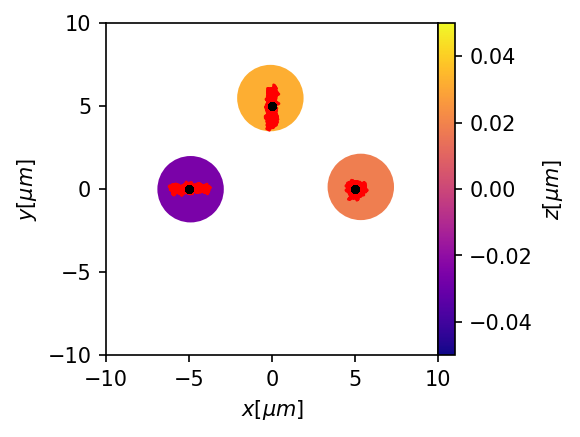

In [20]:
plt.figure(figsize=(3,3),dpi=150)
ax = mgc.draw_trj(trj[trj.type==1],sim,cmap="plasma")

for i, trj_i in trj.groupby("id"):
    if all(trj_i.type==1):
        ax.plot(trj_i.x,trj_i.y, color="red")
    else: 
        ax.plot(trj_i.x,trj_i.y,'.',color="k", linewidth = .5)

This also works well. In principle, a single particle should be able to be traped by several traps if they have a cutoff. Let's see if that works.

In [21]:
region = np.array([20,20,4.1])

In [22]:
particles = mgc.particles(
    np.array([[-2.5,-5,0],[0,5,0],[2.5,-5,0]])*ureg.um,
    radius = 2*ureg.um,
    susceptibility = 0,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

traps = mgc.bistable_trap(
                np.array([[-1,-5,0],[0,5,0]])*ureg.um,
                np.array([[1,0,0],[0,1,0]]),
                particles, subsets = slice(0,2),
                distance = 2*ureg.um,
                height = 0 * ureg.pN*ureg.nm,
                stiffness = 3e-4 * ureg.pN/ureg.nm)

traps2 = mgc.bistable_trap(
                np.array([[1,-5,0]])*ureg.um,
                np.array([[1,0,0]]),
                particles, subsets = [2],
                distance = 0*ureg.um,
                height = 0 * ureg.pN*ureg.nm,
                stiffness = 1e-6 * ureg.pN/ureg.nm,
                cutoff = 10*ureg.um)

In [23]:
field = mgc.field(magnitude = 0*ureg.mT, frequency = 100*ureg.Hz, angle = 90*ureg.degrees)

world = mgc.world(particles, [traps,traps2], temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 20*ureg.um)

In [24]:
sim = mgc.sim(dir_name = "bidisperse/", file_name = "test_traps_pair",
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = 60*ureg.s,
       particles = particles,traps = [traps,traps2], world = world, field = field, 
       output = ["x","y","z","mux","muy","muz"])

In [25]:
sim.generate_scripts()
sim.run()
sim.load()

trj = sim.lazy_read[:]

scanning file


  0%|          | 0/768011 [00:00<?, ?it/s]

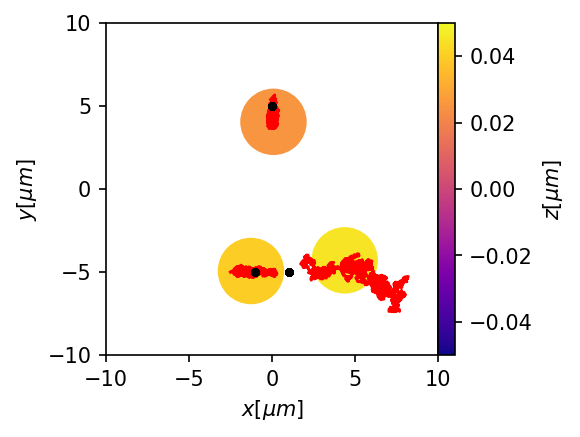

In [26]:
plt.figure(figsize=(3,3),dpi=150)
ax = mgc.draw_trj(trj[trj.type==1],sim,cmap="plasma")

for i, trj_i in trj.groupby("id"):
    if all(trj_i.type==1):
        ax.plot(trj_i.x,trj_i.y, color="red")
    else: 
        ax.plot(trj_i.x,trj_i.y,'.',color="k", linewidth = .5)

This works, but keep in mind that all particles see the pair trap. Currently, I don't know how to make some particles see the pair trap and some not. Maybe this can be implemented in the future by defining several particle types. 

## Bidisperse traps and bidisperse particles


If the list of particle objects `particles`, has $N_p$ particle types, and there are $N_t$ traps of type $t$, `subsets` should be a list of $N_t$ pairs. 
The pair `p = subsets[i]` indicates trap $i$ is to be bonded with particle $p[1]$ in the list `particles[p[0]]`. 


In [27]:
large_particles = mgc.particles(
    np.array([[0,2.5,0]])*ureg.um,
    radius = 2*ureg.um,
    susceptibility = 0,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

small_particles = mgc.particles(
    np.array([[-2.5,0,0],[0,0,0]])*ureg.um,
    radius = 1*ureg.um,
    susceptibility = 0,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

## The trap at [-2.5,0,0] should be paired with the first small particle. 
## The trap at [2.5,0,0] should be paired with the first large particle. 

long_traps = mgc.bistable_trap(
                np.array([[-2.5,0,0],[0,2.5,0]])*ureg.um,
                np.array([[1,0,0],[0,1,0]]),
                [large_particles,small_particles], subsets = [[1,0],[0,0]],
                distance = 2*ureg.um,
                height = 0 * ureg.pN*ureg.nm,
                stiffness = 3e-4 * ureg.pN/ureg.nm)

## The trap at [0,0,0] should be paired with the second small particle. 
short_trap = mgc.bistable_trap(
                np.array([[0,0,0]])*ureg.um,
                np.array([[1,0,0]]),
                [large_particles,small_particles], subsets = [[1,1]],
                distance = 0*ureg.um,
                height = 0 * ureg.pN*ureg.nm,
                stiffness = 3e-4 * ureg.pN/ureg.nm)

In [28]:
field = mgc.field(magnitude = 0*ureg.mT, frequency = 100*ureg.Hz, angle = 90*ureg.degrees)

world = mgc.world([large_particles,small_particles],
                  [long_traps, short_trap], temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'],
                  walls = [False,False,True],
                  dipole_cutoff = 20*ureg.um)

In [29]:
sim = mgc.sim(dir_name = "bidisperse/", file_name = "test_traps_bibi",
       timestep = 1e-4*ureg.s, framerate = 30*ureg.Hz, total_time = 60*ureg.s,
       particles = [large_particles,small_particles],
       traps = [long_traps, short_trap], world = world, field = field, 
       output = ["x","y","z","mux","muy","muz"])

In [30]:
sim.generate_scripts()
sim.run()
sim.load()

trj = sim.lazy_read[:]

scanning file


  0%|          | 0/779482 [00:00<?, ?it/s]

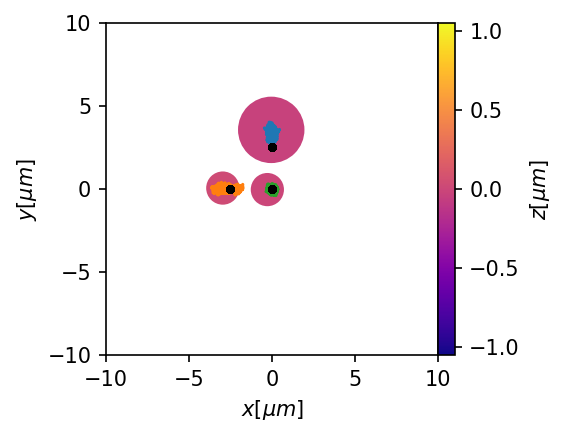

In [31]:
plt.figure(figsize=(3,3),dpi=150)
ax = mgc.draw_trj(trj.query("type<3"),sim,cmap="plasma")

for i, trj_i in trj.groupby("id"):
    if all(trj_i.type<3):
        ax.plot(trj_i.x,trj_i.y)
    else: 
        ax.plot(trj_i.x,trj_i.y,'.',color="k", linewidth = .5)

This last part probably breaks the behaviour above